In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
from sklearn.model_selection import ParameterGrid
from sklearn.manifold import Isomap
import time
from tqdm import tqdm

import librosa
from librosa import cqt
from librosa import core
from librosa.core import amplitude_to_db
from librosa.display import specshow

import os
import glob

## Fig 6a- North Texas Vowel Dataset (Speech)

In [2]:
data_dir= '/Users/sripathisridhar/googleDrive/projects/helix/helix2019_data/NTVOW'

In [3]:
file_paths=  sorted(glob.glob(os.path.join(data_dir, '**' '*.wav')))

In [4]:
q= 24
hop_size= 512

features_dict= {}
feature_key= ''
for file_path in tqdm(file_paths, disable= False):

    # Read audio files
    waveform, sample_rate= librosa.load(file_path, sr=None)

    # Compute CQTs
    cqt_complex= cqt(y= waveform,
                    sr= sample_rate,
                    hop_length= hop_size,
                    bins_per_octave= q,
                    n_bins= q*7,
                    sparsity=1e-6,
                    )
    scalogram= np.abs(cqt_complex)**2

    # Grab middle frame
    feature= scalogram[:,scalogram.shape[1]//2]

    # Stack in dict
    file_name= os.path.basename(file_path)
    feature_key= f'{file_name}'
    features_dict[feature_key]= feature


100%|██████████| 3190/3190 [02:24<00:00, 22.14it/s]


In [5]:
grid= {'Q': [24],
       'age': ['all'],
       'comp': ['log'],
       'k': [3],
       'n': [3]
      }

settings= list(ParameterGrid(grid))

# Map identifiers to search strings
for setting in settings:
        
    if setting['age']=='all':
        setting['age']=''

In [8]:
batch_str= []
q= 0
CQT_OCTAVES= 7

features_keys= list(features_dict.keys())

for setting in tqdm(settings):
    
    q= setting['Q']
    # Batch process and store in a folder
    batch_str= [setting['age']]
    batch_features= []
    for feature_key in features_keys:
        # Get features that match setting
        
        if all(x in feature_key for x in batch_str):
            batch_features.append(features_dict[feature_key])
    
    batch_features= np.stack(batch_features, axis=1)
    
    # Isomap parameters
    hop_size= 512
    compression= 'log'
    features= amplitude_to_db(batch_features)
    n_neighbors= setting['k']
    n_dimensions= 3
    n_octaves= 3    

    # Prune feature matrix
    bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
    bin_high = bin_low + n_octaves*q 
    X = features[bin_low:bin_high, :]

    # Z-score Standardization- improves contrast in correlation matrix
    mus = np.mean(X, axis=1)
    sigmas = np.std(X, axis=1)
    X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

    # Pearson correlation matrix
    rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]
    
    # Isomap embedding
    isomap= Isomap(n_components= n_dimensions, n_neighbors= n_neighbors)
    coords = isomap.fit_transform(rho_std)
    
    # Get note value
    freqs= librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
    chroma_list= librosa.core.hz_to_note(freqs[bin_low:bin_high])
    
    notes=[]
    reps= q//12
    for chroma in chroma_list:
        for i in range(reps):
            notes.append(chroma)

100%|██████████| 1/1 [00:00<00:00, 24.42it/s]


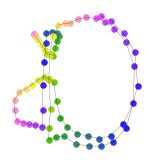

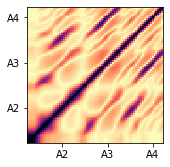

In [9]:
curr_fig= plt.figure(figsize=(5.5, 2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

# Plot Pearson correlation matrix
rho_frequencies = freqs[bin_low:bin_high]

freq_ticklabels = ['A2', 'A3', 'A4']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r')
plt.xticks(tick_bins)
plt.gca().set_xticklabels(freq_ticklabels)
plt.yticks(tick_bins)
plt.gca().set_yticklabels(freq_ticklabels)
plt.gca().invert_yaxis()

plt.clim(0, 1)


## Fig 6b- SONYC (Environmental soundscapes)

In [30]:
import pandas as pd
data_dir = '/Users/sripathisridhar/googleDrive/projects/helix/helix2019_data/SONYC-UST-dev'
csv_name = 'annotations.csv'
csv_path = os.path.join(data_dir, csv_name)

unfiltered_df = pd.read_csv(csv_path, low_memory=False)
df = unfiltered_df[
    (unfiltered_df['annotator_id']==0) &
    (unfiltered_df['6_music_presence']==0) &
    (unfiltered_df['7_human-voice_presence']==0)]

wav_names = list(df["audio_filename"])
wav_dir = os.path.join(data_dir, "validate")
wav_names = sorted(wav_names)

In [31]:
features_dict= {}
feature_key= ''
q= 24
hop_size= 512


for wav_name in tqdm(wav_names, disable=False):
    wav_path = os.path.join(wav_dir, wav_name)
    waveform, sample_rate = librosa.load(wav_path)

    # Compute CQTs
    cqt_complex= cqt(y= waveform,
                    sr= sample_rate,
                    hop_length= hop_size,
                    bins_per_octave= q,
                    n_bins= q*7,
                    sparsity=1e-6,
                    )
    scalogram = np.abs(cqt_complex)**2

    # Find frame with maximum RMS value
    rms= librosa.feature.rms(y=waveform,
                              hop_length= hop_size)
    rms_argmax= np.argmax(rms)
    feature = librosa.amplitude_to_db(scalogram[:,rms_argmax])
    feature_key= f'{wav_name}'
    features_dict[feature_key] = feature

100%|██████████| 233/233 [01:47<00:00,  2.19it/s]


In [32]:
grid={'Q': [24],
          'type': ['all']}

settings= list(ParameterGrid(grid))

grid_map={'all':''}
for setting in settings:
    setting['type']= grid_map[setting['type']]

In [33]:
batch_str= []

features_keys= list(features_dict.keys())

q= 24
CQT_OCTAVES=7

setting=settings[0]
# Batch process and store in a folder
batch_str= [setting['type']]

setting_wavnames= list(df.audio_filename)

batch_features= []
setting_key=''
for setting_wavname in setting_wavnames:
    
    setting_key= f'{setting_wavname}' 
    # get audio files that match setting
    batch_features.append(features_dict[setting_key])

batch_features= np.stack(batch_features, axis=1)

#ISOMAP EMBEDDING INLINE

features= batch_features

bin_low = np.where((np.std(features, axis=1) / np.std(features)) > 0.1)[0][0] + q
bin_high = bin_low + 3*q
X = features[bin_low:bin_high, :]

# Z-score Standardization- improves contrast in correlation matrix
mus = np.mean(X, axis=1)
sigmas = np.std(X, axis=1)
X_std = (X - mus[:, np.newaxis]) / (1e-6 + sigmas[:, np.newaxis]) # 1e-6 to avoid runtime division by zero

# Pearson correlation matrix
rho_std = np.dot(X_std, X_std.T) / X_std.shape[1]

# Isomap embedding
isomap= Isomap(n_components= 3, n_neighbors= 3)
coords = isomap.fit_transform(rho_std)

# Get note value

freqs= librosa.cqt_frequencies(q*CQT_OCTAVES, fmin=librosa.note_to_hz('C1'), bins_per_octave=q) #librosa CQT default fmin is C1
chroma_list= librosa.core.hz_to_note(freqs[bin_low:bin_high])

notes=[]
reps= q//12
for chroma in chroma_list:
    for i in range(reps):
        notes.append(chroma)

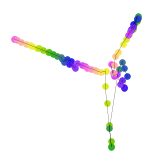

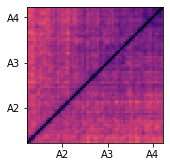

In [36]:
test_list= core.hz_to_note(freqs[bin_low:bin_high], cents=True)
for i,note in enumerate(test_list):
    if note.endswith('-50'):
        test_list[i],_ = note.split('-')
    elif note.endswith('+0'):
        test_list[i],_ = note.split('+')
    elif note.endswith('+50'):
        test_list[i],_ = note.split('+')
        test_list[i]= core.midi_to_note(core.note_to_midi(note, round_midi=False)+0.5 )

chroma= test_list

curr_fig= plt.figure(figsize=(5.5,2.75))
ax= curr_fig.add_subplot(121)
ax.axis('off')

import colorcet as cc
subsampled_color_ids = np.floor(np.linspace(0, 256, q, endpoint=False)).astype('int')
color_list= [cc.cyclic_mygbm_30_95_c78[i] for i in subsampled_color_ids]

# Find first instance of C pitch class to rotate to fixed mapping colormap
rotate_value= next(i for i,x in enumerate(chroma) if x[0]=='C')
color_list= np.roll(color_list, rotate_value, axis=0)

# Plot embedding with color
for i in range(coords.shape[0]):
    plt.scatter(coords[i, 0], coords[i, 1], color= color_list[i%q], s=30.0)

plt.plot(coords[:, 0], coords[:, 1], color='black', linewidth=0.2)

rho_frequencies = freqs[bin_low:bin_high]

freq_ticklabels = ['A2', 'A3', 'A4']
freq_ticks = librosa.core.note_to_hz(freq_ticklabels)

tick_bins = []
tick_labels= []
for i,freq_tick in enumerate(freq_ticks):
    tick_bin = np.argmin(np.abs(rho_frequencies-freq_tick))
    tick_bins.append(tick_bin)
    tick_labels.append(freq_ticklabels[i])

plt.figure(figsize=(2.5,2.5))
plt.imshow(np.abs(rho_std), cmap='magma_r',)
plt.xticks(tick_bins)
plt.gca().set_xticklabels(tick_labels)
plt.yticks(tick_bins)
plt.gca().set_yticklabels(tick_labels)
plt.gca().invert_yaxis()

plt.clim(0, 1)